In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from functools import partial

### Import MNIST data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", validation_size=0, one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### function to save variable summaries for tensorboard

In [3]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### set parameters

In [4]:
learning_rate = 0.01

training_epochs = 50
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 28 * 28


# log directory for tensorboard
log_dir = '/tmp/tensorflow/conv_AE_MNIST/logs'

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [5]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0005):
    with tf.variable_scope(name):
        
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init,
                                kernel_regularizer=l2_regularizer)
        
        layer_vars = layer.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

In [6]:
def conv_layer(name, input_tensor, filters, kernel_size, strides=(1,1), padding='valid', activation=tf.nn.elu, l2_reg = 0.005):
    with tf.variable_scope(name):
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.conv2d(input_tensor, filters, kernel_size, strides=strides, 
                                 padding=padding, activation=activation,
                                 kernel_initializer=he_init,
                                 kernel_regularizer=l2_regularizer)
        
        layer_vars = layer.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

### decoder部

In [7]:
def encoder(x):
    ### Encoder
    conv1 = conv_layer('enc_conv1', X, 30, (5,5), padding='same', activation=tf.nn.relu)
    # Now 28x28x30
    maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
    # Now 14x14x30
    conv2 = conv_layer('enc_conv2', maxpool1, 16, (5,5), padding='same', activation=tf.nn.relu)
    # Now 14x14x16
    maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
    # Now 7x7x16
    conv3 = conv_layer('enc_conv3', maxpool2, 8, (5,5), padding='same', activation=tf.nn.relu)
    # Now 7x7x8
    maxpool3 = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
    # Now 4x4x8
    # Dense Layer
    pool3_flat = tf.reshape(maxpool3, [-1, 4 * 4 * 8])
    dense = nn_layer(pool3_flat, 10, 'dence1', activation=None)
    return dense

### グラフを定義

二乗和誤差を用いてロス値を計算する方法

In [8]:
"""
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
    
    
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = decoder_op

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    cost = tf.reduce_mean(tf.square(y_true - y_pred))
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
"""

"\nwith tf.variable_scope('input'):\n    X = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')\n    \n    \n# Construct model\nwith tf.name_scope('encoder_part'):\n    encoder_op = encoder(X)\n\nwith tf.name_scope('decoder_part'):\n    decoder_op = decoder(encoder_op)\n\n# Prediction\nwith tf.name_scope('prediction'):\n    y_pred = decoder_op\n\n# Targets (Labels) are the input data.\nwith tf.name_scope('target'):\n    y_true = X\n\n# Define loss and optimizer, minimize the squared error\nwith tf.name_scope('reduce_mean'):\n    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))\n    cost = tf.reduce_mean(tf.square(y_true - y_pred))\ntf.summary.scalar('reduce_mean', cost)\n\n\nwith tf.name_scope('train'):\n    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)\n"

### Reset Graph

In [9]:
tf.reset_default_graph()

### グラフを定義

コスト関数：シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

In [10]:
# Construct model
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
    
with tf.variable_scope('label'):
    y_ = tf.placeholder(tf.float32, (None, 10))
    
with tf.variable_scope('encoder_part'):
    encoder_op = encoder(X)
    

# Targets (Labels) are the input data.
with tf.variable_scope('target'):
    y_true = y_

# Define loss and optimizer, minimize the squared error
with tf.variable_scope('reduce_mean'):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=encoder_op)
    cost = tf.reduce_mean(loss)
    

#　精度計算
with tf.variable_scope('correct_prediction'):
    correct_prediction = tf.equal(tf.argmax(encoder_op, 1), tf.argmax(y_true, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))

# model    
model_summary_op = tf.summary.merge_all()
    
    
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    acc_summary_train = tf.summary.scalar("acc_train", accuracy)
    loss_summary_train = tf.summary.scalar("loss_train", cost)

with tf.variable_scope('test'):
    acc_summary_test = tf.summary.scalar("acc_test", accuracy)
    loss_summary_test = tf.summary.scalar("loss_test", cost)
    
with tf.variable_scope("val") as scope:
    acc_summary_val = tf.summary.scalar("acc_val", accuracy)
    loss_summary_val = tf.summary.scalar("loss_val", cost)


## Training

In [11]:
# Initializing the variables
#merged = tf.summary.merge_all()
#merged = tf.summary.merge(
    
train_summary_op = tf.summary.merge([acc_summary_train, loss_summary_train])
test_summary_op = tf.summary.merge([acc_summary_test, loss_summary_test])
    
#train_list = [encorder_pard, train, optimizer, cost, accuracy]

init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')

    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            imgs = batch_x.reshape((-1, 28, 28, 1))
            # Run optimization op (backprop) adn cost op (to get loss value)
            #summary, _, c, a = sess.run([merged, optimizer, cost, accuracy], feed_dict={X: imgs, y_:batch_y})
            model_summary, train_summary, _, c, a = sess.run([model_summary_op, train_summary_op, optimizer, cost, accuracy], 
                                                             feed_dict={X: imgs, y_:batch_y})
        ## Test
        batch_x, batch_y = mnist.test.next_batch(10000) 
        imgs = batch_x.reshape((-1, 28, 28, 1))
        test_summary, c, a = sess.run([test_summary_op, cost, accuracy], 
                                          feed_dict={X: imgs, y_:batch_y})    
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost=", "{:.5f}".format(c), "train acc=", "{:.5f}".format(a), 
                                                "test cost=", "{:.5f}".format(c), "test acc=", "{:.5f}".format(a))
            sys.stdout.flush()
    
        train_writer.add_summary(model_summary, epoch)
        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, log_dir + "model/my_model")

sess.close()

Epoch: 0001 train cost= 0.06136 train acc= 0.98040 test cost= 0.06136 test acc= 0.98040
Epoch: 0002 train cost= 0.04898 train acc= 0.98490 test cost= 0.04898 test acc= 0.98490
Epoch: 0003 train cost= 0.04233 train acc= 0.98640 test cost= 0.04233 test acc= 0.98640
Epoch: 0004 train cost= 0.04030 train acc= 0.98800 test cost= 0.04030 test acc= 0.98800
Epoch: 0005 train cost= 0.03993 train acc= 0.98770 test cost= 0.03993 test acc= 0.98770
Epoch: 0006 train cost= 0.04634 train acc= 0.98680 test cost= 0.04634 test acc= 0.98680
Epoch: 0007 train cost= 0.04366 train acc= 0.98890 test cost= 0.04366 test acc= 0.98890
Epoch: 0008 train cost= 0.05106 train acc= 0.98410 test cost= 0.05106 test acc= 0.98410
Epoch: 0009 train cost= 0.05200 train acc= 0.98640 test cost= 0.05200 test acc= 0.98640
Epoch: 0010 train cost= 0.07465 train acc= 0.98080 test cost= 0.07465 test acc= 0.98080
Epoch: 0011 train cost= 0.04604 train acc= 0.98850 test cost= 0.04604 test acc= 0.98850
Epoch: 0012 train cost= 0.05655 

In [27]:
n_data = 10

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    batch_xs, batch_ys = mnist.test.next_batch(n_data)
    in_imgs = batch_xs.reshape((n_data, 28, 28, 1))
    output = sess.run(encoder_op, feed_dict={X: in_imgs})
    # Compare original images with their reconstructions
    f, a = plt.subplots(1, n_data, figsize=(10, 2))
    for i in range(examples_to_show):
        a[i].imshow(np.reshape(batch_xs[i], (28, 28)))
    print("correct label  : ", np.argmax(batch_ys, axis=1))    
    print("estimated label: ", np.argmax(output, axis=1))
    f.show()

INFO:tensorflow:Restoring parameters from /tmp/tensorflow/conv_AE_MNIST/logsmodel/my_model


NotFoundError: Key hidden_embedding/embedding not found in checkpoint
	 [[Node: save_11/RestoreV2_8 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_11/Const_0_0, save_11/RestoreV2_8/tensor_names, save_11/RestoreV2_8/shape_and_slices)]]

Caused by op 'save_11/RestoreV2_8', defined at:
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-e81b54f9f4e7>", line 3, in <module>
    saver = tf.train.Saver()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key hidden_embedding/embedding not found in checkpoint
	 [[Node: save_11/RestoreV2_8 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_11/Const_0_0, save_11/RestoreV2_8/tensor_names, save_11/RestoreV2_8/shape_and_slices)]]


INFO:tensorflow:Restoring parameters from /tmp/tensorflow/conv_AE_MNIST/logsmodel/my_model


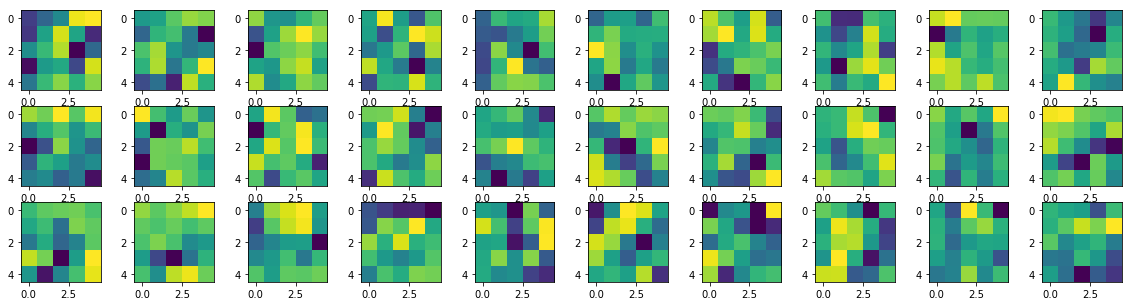

In [20]:
saver = tf.train.Saver()
channel = 10
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    conv1 = sess.run(var[0])
    # Compare original images with their reconstructions
    f, a = plt.subplots(3, channel, figsize=(20, 5))
    for i in range(channel):
        a[0][i].imshow(np.reshape(conv1[:,:,0,3*i], (5, 5)))
        a[1][i].imshow(np.reshape(conv1[:,:,0,3*i+1], (5, 5)))
        a[2][i].imshow(np.reshape(conv1[:,:,0,3*i+2], (5, 5)))

In [17]:
for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(v)

<tf.Variable 'encoder_part/enc_conv1/conv2d/kernel:0' shape=(5, 5, 1, 30) dtype=float32_ref>
<tf.Variable 'encoder_part/enc_conv1/conv2d/bias:0' shape=(30,) dtype=float32_ref>
<tf.Variable 'encoder_part/enc_conv2/conv2d/kernel:0' shape=(5, 5, 30, 16) dtype=float32_ref>
<tf.Variable 'encoder_part/enc_conv2/conv2d/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'encoder_part/enc_conv3/conv2d/kernel:0' shape=(5, 5, 16, 8) dtype=float32_ref>
<tf.Variable 'encoder_part/enc_conv3/conv2d/bias:0' shape=(8,) dtype=float32_ref>
<tf.Variable 'encoder_part/dence1/dense/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'encoder_part/dence1/dense/bias:0' shape=(10,) dtype=float32_ref>


## クラスタリング

中間層の出力をTensorboardでクラスタリングしてみます。

入力：テストデータ
embeddingデータ： 中間層のデータ

In [21]:
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [22]:
n_data = 10000

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    batch_xs, batch_ys = mnist.test.next_batch(n_data)
    imgs = batch_xs.reshape((-1, 28, 28, 1))
    hidden_tmp = sess.run(encoder_op, feed_dict={X: imgs})

INFO:tensorflow:Restoring parameters from /tmp/tensorflow/conv_AE_MNIST/logsmodel/my_model


### メタデータファイルの作成

メタデータファイルは、  
* 最初の行にカラム名を記述  
* メタ情報を2行目以降に記述  

例えば、MNISTの画像のメタデータを作る場合は、以下のように最初のカラムにインデックス、次のカラムにラベル名（数字）を指定します。

In [23]:
# 
#LOG_DIR = "/tmp/tensorflow/conv_AE_MNIST/logs"

# recreate log directory
if tf.gfile.Exists(log_dir + '/projector'):
    tf.gfile.DeleteRecursively(log_dir + '/projector')
tf.gfile.MakeDirs(log_dir + '/projector')

In [24]:
ys = batch_ys
with open(os.path.join(log_dir, 'projector/metadata.tsv'),'w') as f:
    #f.write("Index\tLabel\n")
    for index, label in enumerate(ys):
        f.write('{}\n'.format(label))

### クラスタ用のembeddingを保存

In [26]:
xs = tf.stack(hidden_tmp, axis=0)

with tf.variable_scope('hidden_embedding'):
    embedding_var = tf.Variable(xs, trainable=False, name='embedding')


summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'projector'), sess.graph)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# metadata 
embedding.metadata_path = os.path.join(log_dir, 'projector/metadata.tsv')

# stripe 
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
#embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)


#sess = tf.InteractiveSession()

# initialize "embedding_ver"
init = tf.variables_initializer([embedding_var])

with tf.Session() as sess:
    sess.run(init)
    # specify variable to save 
    saver = tf.train.Saver([embedding_var])
    # save variables 
    saver.save(sess, os.path.join(log_dir, "projector/model.ckpt"), global_step=n_data)

## Tensorboard 起動

tensorboard --logdir=/tmp/tensorflow/tensorboard

In [ ]:
!tensorboard --logdir=/tmp/tensorflow/conv_AE_MNIST

Starting TensorBoard b'54' at http://shinya-no-MacBook-Pro.local:6006
(Press CTRL+C to quit)
Error on request:
Traceback (most recent call last):
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/werkzeug/serving.py", line 209, in run_wsgi
    execute(self.server.app)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/werkzeug/serving.py", line 197, in execute
    application_iter = app(environ, start_response)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/tensorboard/backend/application.py", line 627, in __call__
    return self.data_applications[clean_path](environ, start_response)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/werkzeug/wrappers.py", line 301, in application
    return f(*args[:-2] + (request,))(*args[-2:])
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/tensorboard/backend/application.py", line 359, in _serve_hist

Error on request:
Traceback (most recent call last):
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/werkzeug/serving.py", line 209, in run_wsgi
    execute(self.server.app)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/werkzeug/serving.py", line 197, in execute
    application_iter = app(environ, start_response)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/tensorboard/backend/application.py", line 627, in __call__
    return self.data_applications[clean_path](environ, start_response)
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/werkzeug/wrappers.py", line 301, in application
    return f(*args[:-2] + (request,))(*args[-2:])
  File "/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/tensorboard/backend/application.py", line 359, in _serve_histograms
    values = self._multiplexer.Histograms(run, tag)
  File "/Users/shinya/anaconda/env